# Project Proposal: Exploring Pulsar Star Data

##### Madison Gill, Katie Le, Brooke MacLeod, Nandini Soni

## Introduction


#### Background
    
<p>Pulsar stars are a type of Neutron star that produce radio emission detectable on Earth, and used as probes of space-time, the interstellar medium, and states of matter<sup>1</sup>.</p> They are used to test parts of the theory of relativity, and their light emissions contain information about the physics of Neutron stars<sup>2</sup>.</p>
    


#### Research Question
    
---
<p style="text-align: center;"><b>How accurately can the Integrated Pulse Profile determine if a star is pulsar or non-pulsar?<b> </p>

---
    


#### About The Dataset

To answer the research question, the Pulsar Dataset [HTRU2](https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2) will be used with data collected through the High Time Resolution Universe Survey.  

<p>The dataset uses the mean, standard deviation, excess kurtosis, and skewness of the stars’ IPP and DM-SNR curves.</p>
    
><u>DM-SNR curves:</u>
>Measure the radio waves released by pulsar stars once they reach Earth and have already traveled long distances in space surrounded by free electrons<sup>3</sup>.

><u>Integrated Pulse Profile</u>: 
>Fingerprint of the pulsar. Averaging over thousands of rotations makes the profiles stable<sup>3</sup>.

><u> Excess Kurtosis</u>:
>Distribution of event outcomes have many outliers leading to fat tails on the bell-shaped distribution curve<sup>4</sup>. 
   

## Data Analysis

In [1]:
#1. Download libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(infer)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#2.Read in data Pulsar Star Data

pulsar_star_data<-read_csv("https://raw.githubusercontent.com/madisongill/dsci-100-2023s-group-39-section-002/main/HTRU_2.csv",col_names=FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#3. Tidy data (add column names,condense if needed)(unbalanced unsplit)

pulsar <- pulsar_star_data|>
rename(mean=X1,
       std_dev=X2,
       kurt=X3,
       skew=X4,
       mean_dmsnr=X5,
       std_dev_dmsnr=X6,
       kurt_dmsnr=X7,
       skew_dmsnr=X8,
       class=X9) |>
mutate(class = as_factor(class)) |>
select(mean, std_dev, kurt, skew, class)

<p>The Class variable has been converted to a factor because the corresponding observations are binary: pulsar or non-pulsar.</p>

### Class Imbalance

In [6]:
class_count_unbalanced <- pulsar |> #summarize counts of class labels
    group_by(class) |>
    summarize(count = n())

class_count_unbalanced

class,count
<fct>,<int>
0,16259
1,1639


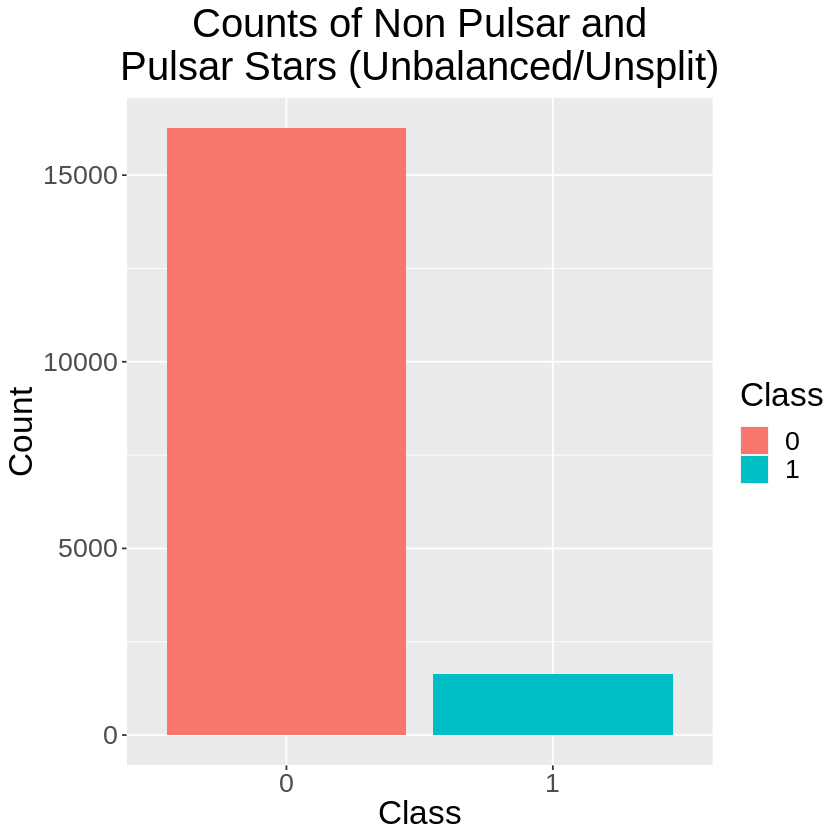

In [8]:
prop_plot <- class_count_unbalanced |> #bar graph to show proportions of classes (visual comparison)
    ggplot(aes(x = class, y = count, fill = class)) +
    geom_bar(stat = "identity") +
    labs(x = "Class", y = "Count", fill = "Class") +
    ggtitle("Counts of Non Pulsar and\nPulsar Stars (Unbalanced/Unsplit)")+
    theme(text = element_text(size = 20)) +
theme(plot.title = element_text(hjust = 0.5))




prop_plot

In [11]:
#balanced, unsplit
pulsar_balanced <- pulsar |> 
    group_by(class) |>
    sample_n(1223)

pulsar_balanced

mean,std_dev,kurt,skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
117.78125,48.83821,0.21125793,-0.192518690,0
78.33594,40.27586,0.75156387,1.858023117,0
152.76562,50.57999,-0.16609347,-0.038770396,0
123.07812,49.09821,0.11204322,-0.226149128,0
135.16406,51.07880,-0.05214817,-0.057502208,0
96.16406,40.99557,0.38420729,0.714285426,0
109.96875,49.82829,0.43904129,0.303314560,0
95.66406,47.60651,0.53599405,0.535184976,0
113.23438,41.06806,0.17078542,0.620676630,0


In [12]:
#4.Split data into training and test set

#balanced, split
pulsar_split<-initial_split(pulsar_balanced,prop=0.75,strata=class)
pulsar_train<-training(pulsar_split)
pulsar_test<-testing(pulsar_split)

#demonstrate data was split
train<-nrow(pulsar_train)

split<-nrow(pulsar_balanced)

percentage_train_data<-train/split*100

test<-nrow(pulsar_test)

percentage_test_data<-test/split*100


#### Summary

The next code cell reduces the columns and summarizes their values. The count and proportion of each Class, average and standard deviation of each variable, and a count of missing values are shown.

In [14]:
number_obs<-nrow(pulsar_train)

class_count_balanced <- pulsar_train |> #summarize counts of class labels
    group_by(class) |>
    summarize(count = n(),
            percent_of_train=n()/number_obs*100) #percentage of pulsar vs non pulsar

summary_train <- pulsar_train |> #the average of all the predictor variables
    select(-class) |>
    map_df(mean) |>
    rename(mean_avg = mean,
           std_dev_avg = std_dev, 
           kurt_avg = kurt,
           skew_avg = skew)

means_and_counts<- as_tibble(sum(is.na(pulsar_train))) |> #checking for na values
    rename(missing_vals = value) |>
    bind_cols(summary_train)  #combine summary_train and missing values check into one

standard_dev <- pulsar_train |> #the standard deviation of all predictor variables, #found the sd function (5)
                    mutate(mean_sd = sd(mean),
                       std_dev_sd = sd(std_dev),
                       kurt_sd = sd(kurt),
                       skew_sd = sd(skew))|>
                    slice(1)|>
                    select(mean_sd,std_dev_sd,kurt_sd,skew_sd)


    

means_and_counts
standard_dev
class_count_balanced

Adding missing grouping variables: `class`
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Adding missing grouping variables: `class`


missing_vals,class,mean_avg,std_dev_avg,kurt_avg,skew_avg
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,NA,86.2707,43.02063,1.673577,7.90833


class,mean_sd,std_dev_sd,kurt_sd,skew_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,17.34183,6.501713,0.3213582,0.9476675
1,29.48453,7.690089,1.8416636,13.7719227


class,count,percent_of_train
<fct>,<int>,<dbl>
0,917,50
1,917,50


#### Visualization

The plot is an example of using the variables to determine Class. From the IPP variables, a relationship can be seen between the excess kurtosis and mean. It appears to be a strong, negative, non-linear relationship.

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

pulsar_star_graph <- pulsar_train |>
ggplot(aes(x = mean, y = kurt, color = class)) +
geom_point(alpha = 0.4) +

labs(x = "Mean of the Integrated Profile", y = "Excess kurtosis of \nthe Integrated Profile", color = "Class") +
scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                   values = c("orange", "steel blue")) +
ggtitle("Determining Class from Mean and Excess\n Kurtosis of Integrated Profile")+
theme(plot.title = element_text(hjust = 0.5))+
theme(text = element_text(size = 20))

pulsar_star_graph

## Methods

The Class will be determined using four variables. Since the IPP alone can determine whether a star is pulsar or non-pulsar, columns related to the DM-SNR curve will be excluded through selecting the mean, standard deviation, kurtosis, and skewness of the IPP.

To ensure the model can be tested, the dataset will first be split into a training and testing set. The variables will be scaled, class imbalance will be fixed. A classification model, using cross-validation, will be created using $k$ nearest neighbors to predict the star type.

The results will be visualized by plotting estimated accuracy against neighbors to show the ideal $k$ value to use. A bar graph containing true positives, false positives, true negatives, and false negatives will be added to highlight the accuracy of the model.

## Significance

<p>The expected outcome is a highly accurate model which predicts the stars’ type. Each IPP of a star is unique, acting as a fingerprint, so the model can determine the star type while trained solely on the IPP variables.
If the model is successful, then only the IPP variables are important in identifying the stars, rather than the DM-SNR curve. This analysis can help with answering future questions such as:</p> 

<p style="text-align: center;"><b>Which factors are effective predictors of star type?<b> </p>
<p style="text-align: center;"><b>Is this relationship between predictor variables applicable to other space phenomena?<b> </p>
<p style="text-align: center;"><b>Would using DM-SNR variables improve the model’s accuracy?<b> </p>
    




## References

1.https://archive.ics.uci.edu/dataset/372/htru2

2.https://www.space.com/32661-pulsars.html#:~:text=Pulsars%20have%20been%20used%20to,first%20time%20in%20February%202016


3.https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2

4.https://www.investopedia.com/terms/e/excesskurtosis.asp#:~:text=Excess%20kurtosis%20means%20the%20distribution,by%20subtracting%20kurtosis%20by%20three.

5.https://www.digitalocean.com/community/tutorials/find-standard-deviation-in-r#:~:text=R%20is%20easy.-,R%20offers%20standard%20function%20sd(%27%20%27)%20to%20find%20the%20standard,through%20indexing%20as%20shown%20above.